# Title: `Real and fake face  detection using ResNet50`

Group Members:

1.     2020/E/034
2.     2020/E/035
3.     2020/E/120


    


# **`Install Necessary Packages`**

*Install wandb, tensorflow, matplotlib, and scikit-learn*

In [ ]:
!pip install wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


# **`Import Libraries`**

*Import the required libraries for data processing, model building, and evaluation.*




In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [ ]:
import wandb
from wandb.keras import WandbCallback

# **`Initialize Wandb`**

*Initialize Wandb for experiment tracking.*

In [ ]:

wandb.init(project="fake-face-detection")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# **`Dataset Paths,Directories for Train, Val, and Test Splits and split the data `**

In [ ]:
# Paths to your dataset
dataset_dir = '/content/drive/MyDrive/Real and Fake Face Detection Dataset'
real_dir = os.path.join(dataset_dir, 'Real')
fake_dir = os.path.join(dataset_dir, 'Fake')

# Create directories for train, val, and test splits
split_dirs = ['train', 'val', 'test']
categories = ['Real', 'Fake']

for split_dir in split_dirs:
    for category in categories:
        os.makedirs(os.path.join(dataset_dir, split_dir, category), exist_ok=True)

# Function to split dataset
def split_data(SOURCE, TRAINING, VALIDATION, TEST, SPLIT_SIZE):
    all_files = []
    for filename in os.listdir(SOURCE):
        file = os.path.join(SOURCE, filename)
        if os.path.getsize(file) > 0:
            all_files.append(filename)
        else:
            print(f'Skipped {filename} because it is empty')

    train_files, temp_files = train_test_split(all_files, test_size=1-SPLIT_SIZE['train'])
    val_files, test_files = train_test_split(temp_files, test_size=SPLIT_SIZE['test']/(SPLIT_SIZE['val']+SPLIT_SIZE['test']))

    def copy_files(files, destination):
        for filename in files:
            this_file = os.path.join(SOURCE, filename)
            destination_file = os.path.join(destination, filename)
            shutil.copyfile(this_file, destination_file)

    copy_files(train_files, TRAINING)
    copy_files(val_files, VALIDATION)
    copy_files(test_files, TEST)

# Define the split sizes
split_size = {'train': 0.7, 'val': 0.15, 'test': 0.15}

# Split the data
split_data(real_dir,
           os.path.join(dataset_dir, 'train', 'Real'),
           os.path.join(dataset_dir, 'val', 'Real'),
           os.path.join(dataset_dir, 'test', 'Real'),
           split_size)
split_data(fake_dir,
           os.path.join(dataset_dir, 'train', 'Fake'),
           os.path.join(dataset_dir, 'val', 'Fake'),
           os.path.join(dataset_dir, 'test', 'Fake'),
           split_size)


# **`Display Sample Images with Labels`**

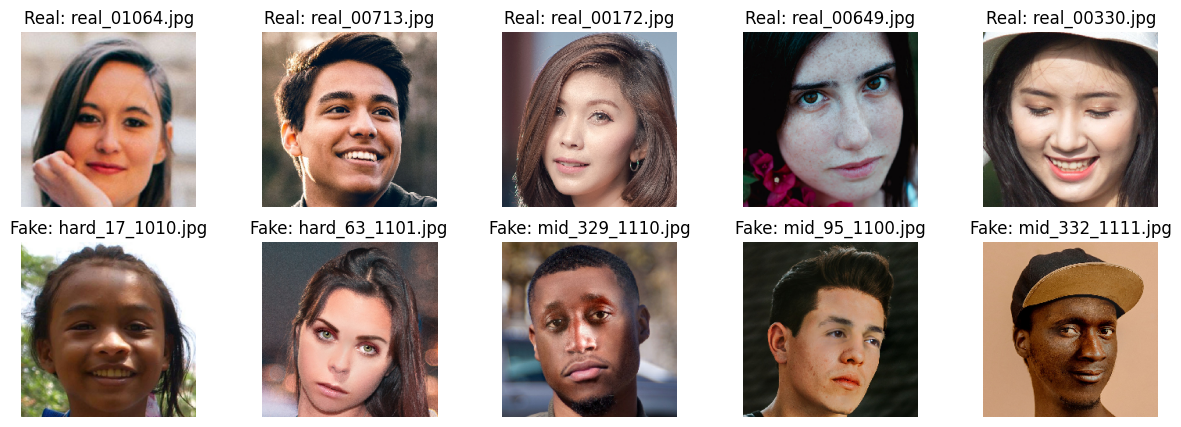

In [ ]:
# Print some sample images with labels
def show_sample_images(dataset_dir, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples*3, 5))
    categories = ['Real', 'Fake']

    for i, category in enumerate(categories):
        category_dir = os.path.join(dataset_dir, category)
        if not os.path.exists(category_dir):
            print(f"Directory {category_dir} does not exist.")
            continue

        sample_files = np.random.choice(os.listdir(category_dir), num_samples, replace=False)

        for j, file in enumerate(sample_files):
            img_path = os.path.join(category_dir, file)
            img = image.load_img(img_path, target_size=(224, 224))
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(f"{category}: {file}")

    plt.show()

# Display sample images
show_sample_images(os.path.join(dataset_dir, 'train'))

# **`Image Data Generators`**
*mage data generators with augmentation for the training set and rescaling for validation and test sets.*

In [ ]:
# Image data generators with augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# **`New SectCreate Data Generatorsion`**
#
*italidata generators for training, validation, and test sets.cized text*


In [ ]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 1870 images belonging to 2 classes.
Found 572 images belonging to 2 classes.
Found 572 images belonging to 2 classes.


# **`Pre-trained ResNet50 Model`**

*ResNet50 model pre-trained on ImageNet and modify it for binary classification.*

In [ ]:
# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

94765736/94765736 [==============================] - 1s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

# **`callbacks and model training `**

*callbacks for early stopping, model checkpoint, learning rate reduction, and wandb logging.*

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
wandb_callback = WandbCallback()

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, wandb_callback]
)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training
history_fine = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, wandb_callback]
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
59/59 [==============================] - ETA: 0s - loss: 0.7893 - accuracy: 0.5128

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 0.9s


59/59 [==============================] - 543s 9s/step - loss: 0.7893 - accuracy: 0.5128 - val_loss: 0.7157 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.5278

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 0.9s


59/59 [==============================] - 531s 9s/step - loss: 0.7457 - accuracy: 0.5278 - val_loss: 0.6887 - val_accuracy: 0.5699 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 502s 9s/step - loss: 0.7304 - accuracy: 0.5369 - val_loss: 0.6964 - val_accuracy: 0.4685 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - ETA: 0s - loss: 0.7129 - accuracy: 0.5267

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 0.7s


59/59 [==============================] - 529s 9s/step - loss: 0.7129 - accuracy: 0.5267 - val_loss: 0.6881 - val_accuracy: 0.5524 - lr: 0.0010
Epoch 5/50
59/59 [==============================] - 522s 9s/step - loss: 0.7134 - accuracy: 0.5305 - val_loss: 0.6912 - val_accuracy: 0.5420 - lr: 0.0010
Epoch 6/50
59/59 [==============================] - 496s 8s/step - loss: 0.7017 - accuracy: 0.5364 - val_loss: 0.6899 - val_accuracy: 0.5315 - lr: 0.0010
Epoch 7/50
59/59 [==============================] - 526s 9s/step - loss: 0.6962 - accuracy: 0.5561 - val_loss: 0.6895 - val_accuracy: 0.5524 - lr: 0.0010
Epoch 8/50
59/59 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.5594

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 1.2s


59/59 [==============================] - 517s 9s/step - loss: 0.6841 - accuracy: 0.5594 - val_loss: 0.6856 - val_accuracy: 0.5787 - lr: 2.0000e-04
Epoch 9/50
59/59 [==============================] - ETA: 0s - loss: 0.6972 - accuracy: 0.5417

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 0.7s


59/59 [==============================] - 577s 10s/step - loss: 0.6972 - accuracy: 0.5417 - val_loss: 0.6838 - val_accuracy: 0.5997 - lr: 2.0000e-04
Epoch 10/50
59/59 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.5567

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 0.6s


59/59 [==============================] - 555s 9s/step - loss: 0.6869 - accuracy: 0.5567 - val_loss: 0.6826 - val_accuracy: 0.5717 - lr: 2.0000e-04
Epoch 11/50
59/59 [==============================] - 500s 8s/step - loss: 0.6885 - accuracy: 0.5545 - val_loss: 0.6840 - val_accuracy: 0.5699 - lr: 2.0000e-04
Epoch 12/50
59/59 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.5583

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 0.8s


59/59 [==============================] - 520s 9s/step - loss: 0.6829 - accuracy: 0.5583 - val_loss: 0.6798 - val_accuracy: 0.5682 - lr: 2.0000e-04
Epoch 13/50
59/59 [==============================] - 502s 9s/step - loss: 0.6795 - accuracy: 0.5620 - val_loss: 0.6819 - val_accuracy: 0.5647 - lr: 2.0000e-04
Epoch 14/50
59/59 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5353

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 0.9s


59/59 [==============================] - 535s 9s/step - loss: 0.6903 - accuracy: 0.5353 - val_loss: 0.6797 - val_accuracy: 0.5559 - lr: 2.0000e-04
Epoch 15/50
59/59 [==============================] - ETA: 0s - loss: 0.6865 - accuracy: 0.5492

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 0.7s


59/59 [==============================] - 549s 9s/step - loss: 0.6865 - accuracy: 0.5492 - val_loss: 0.6787 - val_accuracy: 0.5542 - lr: 2.0000e-04
Epoch 16/50
59/59 [==============================] - ETA: 0s - loss: 0.6747 - accuracy: 0.5877

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 0.6s


59/59 [==============================] - 530s 9s/step - loss: 0.6747 - accuracy: 0.5877 - val_loss: 0.6768 - val_accuracy: 0.5559 - lr: 2.0000e-04
Epoch 17/50
59/59 [==============================] - 501s 8s/step - loss: 0.6815 - accuracy: 0.5642 - val_loss: 0.6773 - val_accuracy: 0.5682 - lr: 2.0000e-04
Epoch 18/50
59/59 [==============================] - 499s 8s/step - loss: 0.6791 - accuracy: 0.5652 - val_loss: 0.6801 - val_accuracy: 0.5542 - lr: 2.0000e-04
Epoch 19/50
59/59 [==============================] - 498s 8s/step - loss: 0.6797 - accuracy: 0.5578 - val_loss: 0.6776 - val_accuracy: 0.5420 - lr: 2.0000e-04
Epoch 20/50
59/59 [==============================] - 498s 8s/step - loss: 0.6757 - accuracy: 0.5749 - val_loss: 0.6770 - val_accuracy: 0.5472 - lr: 4.0000e-05
Epoch 21/50
59/59 [==============================] - 530s 9s/step - loss: 0.6777 - accuracy: 0.5610 - val_loss: 0.6769 - val_accuracy: 0.5455 - lr: 4.0000e-05
Epoch 22/50
59/59 [==============================] - ETA: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 0.9s


59/59 [==============================] - 521s 9s/step - loss: 0.6788 - accuracy: 0.5594 - val_loss: 0.6765 - val_accuracy: 0.5524 - lr: 4.0000e-05
Epoch 23/50
59/59 [==============================] - ETA: 0s - loss: 0.6798 - accuracy: 0.5647

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 0.7s


59/59 [==============================] - 519s 9s/step - loss: 0.6798 - accuracy: 0.5647 - val_loss: 0.6761 - val_accuracy: 0.5559 - lr: 4.0000e-05
Epoch 24/50
59/59 [==============================] - 494s 8s/step - loss: 0.6771 - accuracy: 0.5599 - val_loss: 0.6762 - val_accuracy: 0.5542 - lr: 4.0000e-05
Epoch 25/50
59/59 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.5588

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 0.7s


59/59 [==============================] - 529s 9s/step - loss: 0.6810 - accuracy: 0.5588 - val_loss: 0.6759 - val_accuracy: 0.5612 - lr: 4.0000e-05
Epoch 26/50
59/59 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.5690

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 0.8s


59/59 [==============================] - 563s 10s/step - loss: 0.6723 - accuracy: 0.5690 - val_loss: 0.6745 - val_accuracy: 0.5629 - lr: 4.0000e-05
Epoch 27/50
59/59 [==============================] - 531s 9s/step - loss: 0.6836 - accuracy: 0.5615 - val_loss: 0.6750 - val_accuracy: 0.5577 - lr: 4.0000e-05
Epoch 28/50
59/59 [==============================] - 500s 8s/step - loss: 0.6822 - accuracy: 0.5583 - val_loss: 0.6746 - val_accuracy: 0.5612 - lr: 4.0000e-05
Epoch 29/50
59/59 [==============================] - ETA: 0s - loss: 0.6695 - accuracy: 0.5914

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 0.9s


59/59 [==============================] - 523s 9s/step - loss: 0.6695 - accuracy: 0.5914 - val_loss: 0.6741 - val_accuracy: 0.5629 - lr: 4.0000e-05
Epoch 30/50
59/59 [==============================] - 505s 8s/step - loss: 0.6769 - accuracy: 0.5706 - val_loss: 0.6751 - val_accuracy: 0.5542 - lr: 4.0000e-05
Epoch 31/50
59/59 [==============================] - 524s 9s/step - loss: 0.6740 - accuracy: 0.5717 - val_loss: 0.6747 - val_accuracy: 0.5629 - lr: 4.0000e-05
Epoch 32/50
59/59 [==============================] - 498s 8s/step - loss: 0.6789 - accuracy: 0.5781 - val_loss: 0.6747 - val_accuracy: 0.5612 - lr: 4.0000e-05
Epoch 33/50
59/59 [==============================] - 525s 9s/step - loss: 0.6724 - accuracy: 0.5845 - val_loss: 0.6748 - val_accuracy: 0.5647 - lr: 8.0000e-06
Epoch 34/50
59/59 [==============================] - 495s 8s/step - loss: 0.6729 - accuracy: 0.5722 - val_loss: 0.6747 - val_accuracy: 0.5629 - lr: 8.0000e-06
Epoch 35/50
59/59 [==============================] - 525s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 1.2s


59/59 [==============================] - 627s 11s/step - loss: 0.6894 - accuracy: 0.5471 - val_loss: 0.6734 - val_accuracy: 0.6136 - lr: 2.0000e-06
Epoch 12/50
59/59 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.5578

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 1.1s


59/59 [==============================] - 618s 10s/step - loss: 0.6905 - accuracy: 0.5578 - val_loss: 0.6729 - val_accuracy: 0.6189 - lr: 2.0000e-06
Epoch 13/50
59/59 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.5529

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240708_080718-noq4lgyw/files/model-best)... Done. 1.7s


59/59 [==============================] - 633s 11s/step - loss: 0.6882 - accuracy: 0.5529 - val_loss: 0.6716 - val_accuracy: 0.6084 - lr: 2.0000e-06
Epoch 14/50
59/59 [==============================] - 619s 11s/step - loss: 0.6908 - accuracy: 0.5401 - val_loss: 0.6732 - val_accuracy: 0.6119 - lr: 2.0000e-06
Epoch 15/50
59/59 [==============================] - 592s 10s/step - loss: 0.6864 - accuracy: 0.5717 - val_loss: 0.6742 - val_accuracy: 0.6014 - lr: 2.0000e-06
Epoch 16/50
59/59 [==============================] - 623s 11s/step - loss: 0.6869 - accuracy: 0.5529 - val_loss: 0.6749 - val_accuracy: 0.6084 - lr: 2.0000e-06
Epoch 17/50
59/59 [==============================] - 590s 10s/step - loss: 0.6821 - accuracy: 0.5652 - val_loss: 0.6752 - val_accuracy: 0.5997 - lr: 1.0000e-06
Epoch 18/50
59/59 [==============================] - 592s 10s/step - loss: 0.6819 - accuracy: 0.5652 - val_loss: 0.6751 - val_accuracy: 0.5979 - lr: 1.0000e-06
Epoch 19/50
59/59 [==============================] -

# **`Model Evaluation`**

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

18/18 [==============================] - 124s 7s/step - loss: 0.6669 - accuracy: 0.5962
Test Accuracy: 59.62%


# ***Final Model Saving***

In [ ]:
# Save the final model
model.save('final_model.h5')

# Load the saved model
loaded_model = tf.keras.models.load_model('final_model.h5')# Save the final model
model.save('final_model.h5')

# Load the saved model
loaded_model = tf.keras.models.load_model('final_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## ***`***`Check the Model Prediction`***`***

In [ ]:
# Function to preprocess and predict an image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = loaded_model.predict(img_array)
    if prediction[0] > 0.5:
        return "Fake", prediction[0]
    else:
        return "Real", 1 - prediction[0]

In [ ]:
pip install tensorflow wandb matplotlib scikit-learn


1/1 [==============================] - 0s 405ms/step
The predicted label is: Fake with confidence: 81.48%


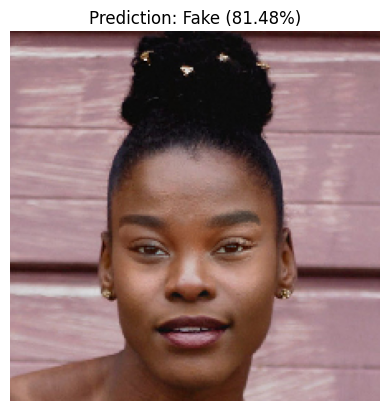

In [ ]:
# Function to preprocess and predict an image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = loaded_model.predict(img_array)
    if prediction[0] > 0.5:
        return "Fake", prediction[0][0]
    else:
        return "Real", 1 - prediction[0][0]

# Test the model with an individual image
test_image_path = '/content/drive/MyDrive/Real and Fake Face Detection Dataset/test/Fake/hard_70_1100.jpg'  # Replace with your image path
label, confidence = predict_image(test_image_path)
print(f'The predicted label is: {label} with confidence: {confidence * 100:.2f}%')

# Plot the test image with the prediction
img = image.load_img(test_image_path, target_size=(224, 224))
plt.imshow(img)
plt.title(f'Prediction: {label} ({confidence * 100:.2f}%)')
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 483ms/step
The predicted label is: Real with confidence: 92.86%


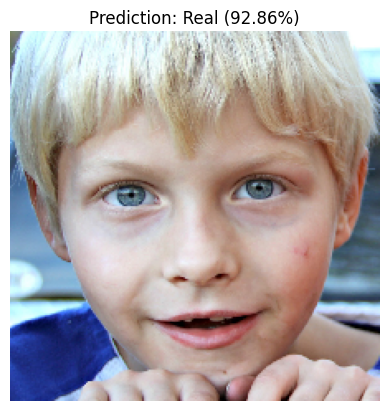

In [ ]:
# Function to preprocess and predict an image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = loaded_model.predict(img_array)
    if prediction[0] > 0.5:
        return "Fake", prediction[0][0]
    else:
        return "Real", 1 - prediction[0][0]

# Test the model with an individual image
test_image_path = '/content/drive/MyDrive/Real and Fake Face Detection Dataset/test/Real/real_00037.jpg'  # Replace with your image path
label, confidence = predict_image(test_image_path)
print(f'The predicted label is: {label} with confidence: {confidence * 100:.2f}%')

# Plot the test image with the prediction
img = image.load_img(test_image_path, target_size=(224, 224))
plt.imshow(img)
plt.title(f'Prediction: {label} ({confidence * 100:.2f}%)')
plt.axis('off')
plt.show()


# ***Check Testing Folder Dataset***

1/1 [==============================] - 0s 198ms/step


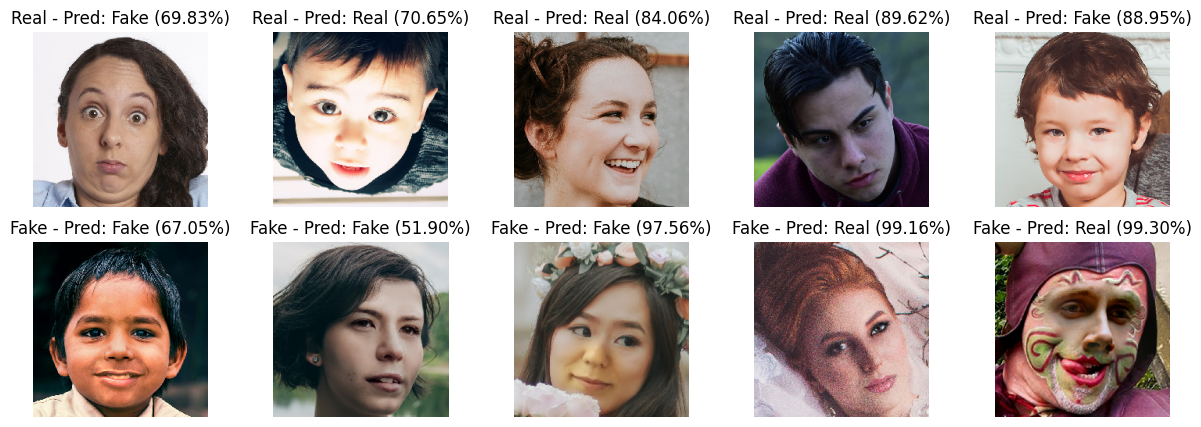

In [ ]:
# Function to display images from the test set with true labels and predictions
def show_test_predictions(test_dir, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples*3, 5))
    categories = ['Real', 'Fake']

    for i, category in enumerate(categories):
        category_dir = os.path.join(test_dir, category)
        sample_files = np.random.choice(os.listdir(category_dir), num_samples, replace=False)

        for j, file in enumerate(sample_files):
            img_path = os.path.join(category_dir, file)
            img = image.load_img(img_path, target_size=(224, 224))
            label, confidence = predict_image(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(f'{category} - Pred: {label} ({confidence * 100:.2f}%)')

    plt.show()

# Display sample test images with true labels and predictions
show_test_predictions(os.path.join(dataset_dir, 'test'))

# **`Model Accuracy and loss plot`**

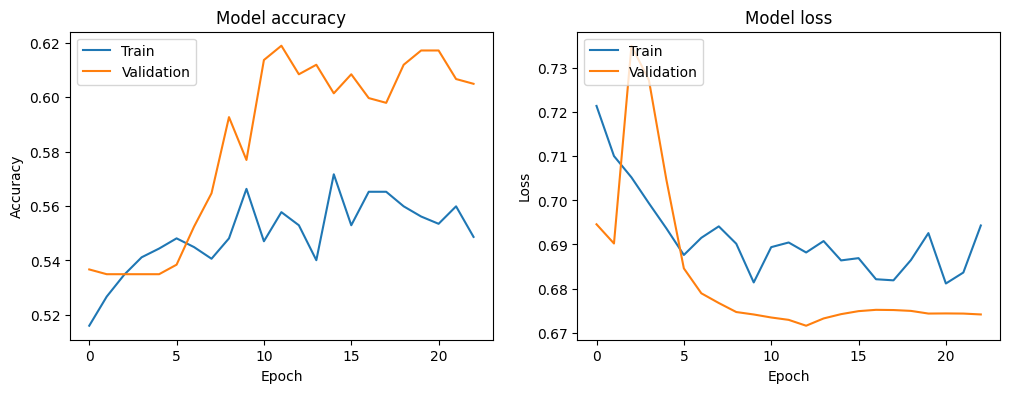

In [ ]:
# Plot training & validation accuracy and loss curves
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Plot accuracy and loss curves
plot_history(history_fine)

# **`Confusion Matrix `**

18/18 [==============================] - 116s 6s/step


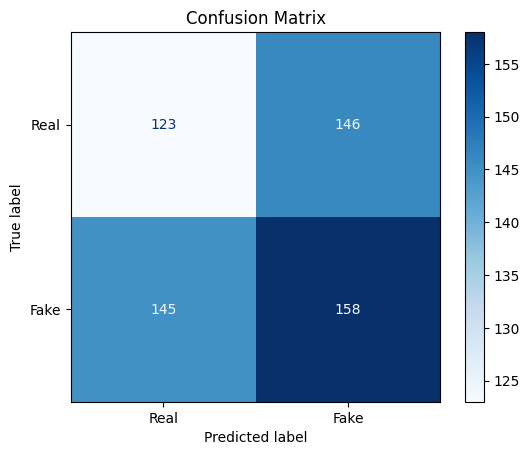

              precision    recall  f1-score   support

        Real       0.46      0.46      0.46       269
        Fake       0.52      0.52      0.52       303

    accuracy                           0.49       572
   macro avg       0.49      0.49      0.49       572
weighted avg       0.49      0.49      0.49       572



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Get predictions and true labels
test_generator.reset()
predictions = (model.predict(test_generator) > 0.5).astype("int32")
true_labels = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Real', 'Fake'])

# Plot confusion matrix
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(true_labels, predictions, target_names=['Real', 'Fake']))


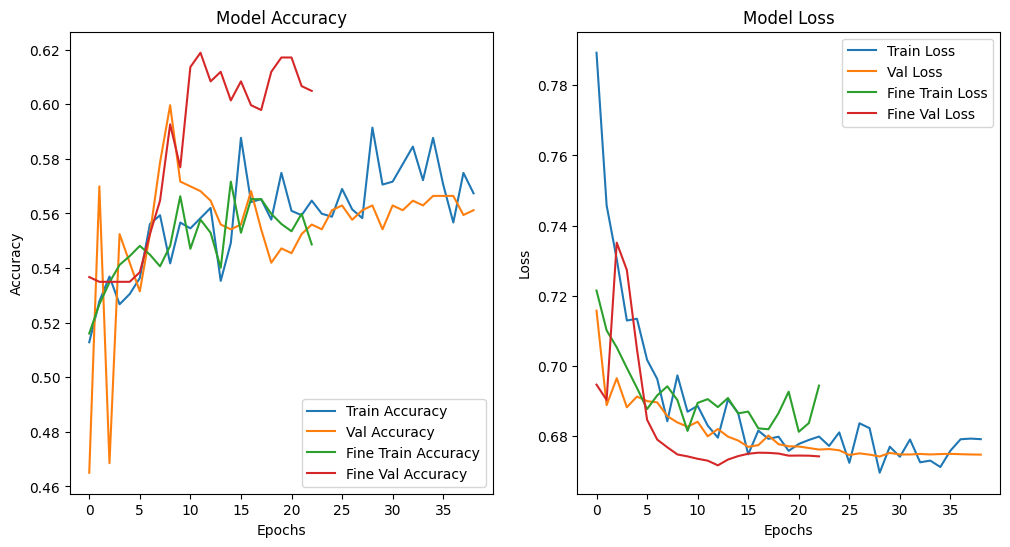

In [ ]:
# Plot the training history
def plot_training_history(history, history_fine):
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.plot(history_fine.history['accuracy'], label='Fine Train Accuracy')
    plt.plot(history_fine.history['val_accuracy'], label='Fine Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.plot(history_fine.history['loss'], label='Fine Train Loss')
    plt.plot(history_fine.history['val_loss'], label='Fine Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.show()

# Plot the training history
plot_training_history(history, history_fine)


1/1 [==============================] - 0s 344ms/step
The predicted label is: Fake with confidence: 89.88%


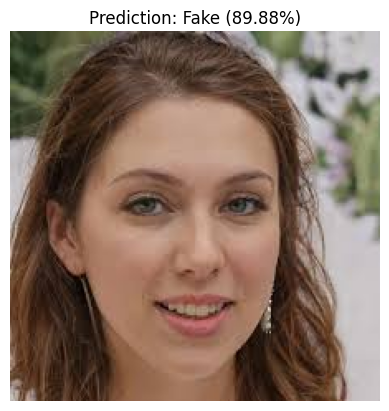

In [ ]:
# Function to preprocess and predict an image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = loaded_model.predict(img_array)
    if prediction[0] > 0.5:
        return "Fake", prediction[0][0]
    else:
        return "Real", 1 - prediction[0][0]

# Test the model with an individual image
test_image_path = '/content/drive/MyDrive/imafges.jpeg'  # Replace with your image path
label, confidence = predict_image(test_image_path)
print(f'The predicted label is: {label} with confidence: {confidence * 100:.2f}%')

# Plot the test image with the prediction
img = image.load_img(test_image_path, target_size=(224, 224))
plt.imshow(img)
plt.title(f'Prediction: {label} ({confidence * 100:.2f}%)')
plt.axis('off')
plt.show()
